In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import data_process as dp

import os
if not os.path.exists('./Plots'):
    os.mkdir('./Plots')

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
import logit_analysis as logit

In [3]:
truncation_choices = [0.9, 0.8, 0.7]
plot_legend = []
for el in truncation_choices:
    plot_legend.append("Cap " + str(el))

df = pd.read_pickle('full_experiment_data.pkl')
print(df.shape[0],"original number of subjects")
for el in truncation_choices:
    print(df[df['probability_truncation'] == el].shape[0], "subjects in %.1lf cap group" % el)
print('')

#Filtering out too many quiz fails
df = df[df['quiz_failed'] < 2]

#Discarding subjects who kept loosing buttons for too long
experiment_total = dp.Decision_Process(df, drop_first_button=False)
suboptimal_subjects = np.array([True if max([(btn[:,1]-btn[:,0]).max() for btn in subj]) > 20 else False for subj in experiment_total.subjects_button_activity])
df = df[~suboptimal_subjects]
print(df.shape[0],"subjects remain after filtering")

experiment_total = dp.Decision_Process(df, drop_first_button=False)
experiment_split = []
for el in truncation_choices:
    truncation_split = df[df['probability_truncation'] == el]
    experiment_split.append(dp.Decision_Process(truncation_split))
    print(truncation_split.shape[0], "subjects in %.1lf cap group remain after filtering" % el)

3632 original number of subjects
1214 subjects in 0.9 cap group
1203 subjects in 0.8 cap group
1215 subjects in 0.7 cap group

3390 subjects remain after filtering
1151 subjects in 0.9 cap group remain after filtering
1125 subjects in 0.8 cap group remain after filtering
1114 subjects in 0.7 cap group remain after filtering


In [4]:
df.head

<bound method NDFrame.head of       subjectID                prolificID  probability_truncation  inst_time  \
0       4610916  5c71b63c4aa8ec0001f2bfc4                     0.8      26451   
1      38505644  5eceed79840590300f53fa51                     0.7      12032   
2      81698333  5e86c320939b3030601f7fcb                     0.8      26082   
3      17600547  6110d7f556da416401efdd5f                     0.7      32050   
4       3000333  60d3740f31606cb50e49f00c                     0.9      53103   
...         ...                       ...                     ...        ...   
3627   95076391  5effca0389eb590c6eed8d4d                     0.9      54345   
3628    1552183  5e4efd2f00f6070a930f3499                     0.8      91578   
3629   93070205  5e7694014add7908e8cedec2                     0.9      54579   
3630   84598840  60ff0549421c4bf5359d7a41                     0.9      58121   
3631     490623  5ed67ff47f3ee30bb86925f5                     0.9      44858   

      tut

In [5]:
totalPeople = df.shape[0]

for j in range(totalPeople):
    try:
        totalTime = 0
        for i in range(len(df.loc[j, 'press_data'])):
            # print(df.loc[0, 'press_data'][i])                
            # failPressTime.append(df.loc[j, 'press_data'][i]['press_time'])
            totalTime += df.loc[j, 'press_data'][i]['press_time']
            # successPressTime.append(df.loc[j, 'press_data'][i]['press_time'])
        df.loc[j, 'total_time'] = totalTime
    except:
        continue

In [6]:
meanTime = df['total_time'].mean()
lessThanMean = df[df['total_time'] < meanTime]
moreThanMean = df[df['total_time'] > meanTime]

# Get two arrays of wins of people who are faster and slower than the mean
lessThanMeanWins = []
moreThanMeanWins = []
for i in range(len(lessThanMean)):
    lessThanMeanWins.append(lessThanMean.iloc[i]['total_win'])
for i in range(len(moreThanMean)):
    moreThanMeanWins.append(moreThanMean.iloc[i]['total_win'])

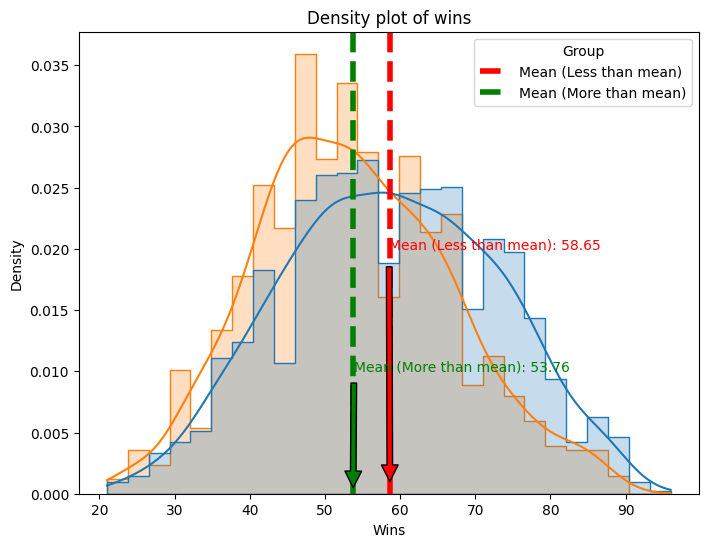

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming lessThanMeanWins and moreThanMeanWins are lists
df = pd.DataFrame({
    'Wins': lessThanMeanWins + moreThanMeanWins,
    'Group': ['Less than mean']*len(lessThanMeanWins) + ['More than mean']*len(moreThanMeanWins)
})

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(df, x='Wins', hue='Group', element='step', stat='density', common_norm=False, kde=True, ax=ax)
ax.set(title='Density plot of wins', xlabel='Wins', ylabel='Density')
    
for group, color, label in [('Less than mean', 'red', 'Mean (Less than mean)'), ('More than mean', 'green', 'Mean (More than mean)')]:
    mean = df[df['Group'] == group]['Wins'].mean()
    ax.axvline(x=mean, color=color, linestyle='dashed', linewidth=4, label=label)
    # Adjust the position of the text annotation based on the group
    xytext = (mean - 0.1, 0.02) if group == 'Less than mean' else (mean + 0.1, 0.01)
    ax.annotate(f'{label}: {mean:.2f}', xy=(mean, 0), xytext=xytext,
                arrowprops=dict(facecolor=color, shrink=0.05), color=color, fontsize=10)

ax.legend(title='Group')
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from pingouin import compute_effsize

In [17]:
t_stat, p_val = ttest_ind(lessThanMeanWins, moreThanMeanWins)
print('t-statistic:', t_stat)
threshold = 0.05
if p_val < threshold:
    print('Reject Null Hypothesis')
else:
    print('Fail to Reject Null Hypothesis')

t-statistic: 9.713278208035325
Reject Null Hypothesis


In [18]:
# Shapiro Wilk Test

stat, p = shapiro(lessThanMeanWins)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Less than mean wins are normally distributed')
else:
    print('Less than mean wins are not normally distributed')

stat, p = shapiro(moreThanMeanWins)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('More than mean wins are normally distributed')
else:
    print('More than mean wins are not normally distributed')

Statistics=0.993, p=0.000
Less than mean wins are not normally distributed
Statistics=0.993, p=0.000
More than mean wins are not normally distributed


In [19]:
stat, p = mannwhitneyu(lessThanMeanWins, moreThanMeanWins)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Fail to reject Null Hypothesis')
else:
    print('Reject Null Hypothesis')

Statistics=1423354.500, p=0.000
Reject Null Hypothesis


In [20]:
effSize = compute_effsize(lessThanMeanWins, moreThanMeanWins, eftype='cohen')
print('Effect Size:', effSize)

Effect Size: 0.35521626937446815
